## Titanic with Keras using TensorFlow backend
Submission scored: 0.80861

### Load data, fill missing Fare and Embarked

In [80]:
import pandas as pd

train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')
total = pd.concat([train.drop('Survived', axis=1), test], ignore_index=True)
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


In [81]:
# Both paid $80 for Pclass 1, which is the median Fare for people with Embarked=C and Pclass=1
total.loc[61,'Embarked'] = 'C'
total.loc[829,'Embarked'] = 'C'

# Fill in with the median Fare of pclass=3 and Embarked=S
total.loc[1043, 'Fare'] = 8.05

### Add new features Title, FamilySize, FamilyID, convert Cabin column

In [82]:
total['Title'] = total.Name.apply(lambda name: name.split(', ')[1].split('. ')[0])

title_map = {
    'Capt':'Sir',
    'Don':'Sir',
    'Major':'Sir',
    'Mme':'Mlle',
    'Dona':'Lady',
    'Jonkheer':'Lady',
    'the Countess':'Lady'
}

total['Title'] = total.Title.apply(lambda title: title_map[title] if title in title_map else title)

total.Title.value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Rev         8
Dr          8
Sir         5
Col         4
Lady        4
Mlle        3
Ms          2
Name: Title, dtype: int64

In [83]:
total['FamilySize'] = total.SibSp + total.Parch + 1
total['FamilyID'] = total.Name.apply(lambda name: name.split(',')[0]) + total.FamilySize.astype('str')
total.loc[total.FamilySize < 2, 'FamilyID'] = 'Single'

In [84]:
total.FamilyID.value_counts().head(10)

Single        790
Sage11         11
Andersson7      9
Goodwin8        8
Asplund7        7
Panula6         6
Skoog6          6
Rice6           6
Fortune6        6
Davies3         5
Name: FamilyID, dtype: int64

In [85]:
total.loc[total.Cabin.isnull(), 'Cabin'] = 'X'
total.Cabin = total.Cabin.apply(lambda cabin: cabin[0])

In [86]:
# Now only Age has missing values

total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Title          1309 non-null object
FamilySize     1309 non-null int64
FamilyID       1309 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 143.2+ KB


### Convert all categorical values to dummy values

In [87]:
pclass_dummies = pd.get_dummies(total.Pclass, prefix='Pclass')
cabin_dummies = pd.get_dummies(total.Cabin, prefix='Cabin')
embarked_dummies = pd.get_dummies(total.Embarked, prefix='Embarked')
title_dummies = pd.get_dummies(total.Title, prefix='Title')
sibsp_dummies = pd.get_dummies(total.SibSp, prefix='SibSp')
parch_dummies = pd.get_dummies(total.Parch, prefix='Parch')
familySize_dummies = pd.get_dummies(total.FamilySize, prefix='FamilySize')
familyID_dummies = pd.get_dummies(total.FamilyID, prefix='FamilyID')

total = pd.concat([total, 
                   pclass_dummies, 
                   cabin_dummies, 
                   embarked_dummies, 
                   title_dummies, 
                   sibsp_dummies, 
                   parch_dummies, 
                   familyID_dummies, 
                   familySize_dummies
                  ], axis=1)

total.Sex = total.Sex.map({'female':0, 'male':1})

total = total.drop(['PassengerId', 
                    'Pclass', 
                    'Name', 
                    'Ticket', 
                    'Cabin', 
                    'Embarked', 
                    'Title', 
                    'SibSp', 
                    'Parch', 
                    'FamilyID', 
                    'FamilySize'
                   ], axis=1)

In [88]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Columns: 281 entries, Sex to FamilySize_11
dtypes: float64(2), int64(1), uint8(278)
memory usage: 386.1 KB


### Predicting missing Ages

In [89]:
from keras.models import Sequential
from keras.layers import Dense

In [90]:
import numpy as np

X = total[total.Age.notnull()].drop('Age', axis=1)
Y = np.array(total[total.Age.notnull()]['Age'])
X_test = total[total.Age.isnull()].drop('Age', axis=1)

In [91]:
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X)

# Scale the train set
X = scaler.transform(X)

# Scale the test set
X_test = scaler.transform(X_test)

In [92]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

for train_part, test_part in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(600, use_bias=True, input_dim=280, activation='relu'))
    model.add(Dense(20, use_bias=True, activation='relu'))
    model.add(Dense(1, use_bias=True))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    model.fit(X[train_part], Y[train_part], epochs=10, batch_size=1, verbose=0)
    mse_value, mae_value = model.evaluate(X[test_part], Y[test_part], verbose=0)
    print(mse_value, mae_value)

/home/yuqing/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


132.199149087 8.42642634519
130.383336361 8.60191303407
157.478430118 9.24614517644
114.808420817 8.18029097015
105.629839005 7.79454070266


In [93]:
# Initialize the model
model = Sequential()

# Add input layer 
model.add(Dense(600, input_dim=280, use_bias=True, activation='relu'))

# Add one hidden layer
model.add(Dense(20, use_bias=True, activation='relu'))

# Add output layer 
model.add(Dense(1, use_bias=True))

# Compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Fit the model
model.fit(X, Y, epochs=10, batch_size=1, verbose=1)

Epoch 1/10
1046/1046 [==============================] - 3s - loss: 210.3917 - mean_absolute_error: 11.1607     
Epoch 2/10
1046/1046 [==============================] - 3s - loss: 119.2253 - mean_absolute_error: 8.3191     
Epoch 3/10
1046/1046 [==============================] - 3s - loss: 103.2567 - mean_absolute_error: 7.5512     
Epoch 4/10
1046/1046 [==============================] - 3s - loss: 92.9825 - mean_absolute_error: 7.2107     
Epoch 5/10
1046/1046 [==============================] - 3s - loss: 90.7141 - mean_absolute_error: 6.9719     
Epoch 6/10
1046/1046 [==============================] - 3s - loss: 86.4519 - mean_absolute_error: 6.7858     
Epoch 7/10
1046/1046 [==============================] - 3s - loss: 86.0162 - mean_absolute_error: 6.6815     
Epoch 8/10
1046/1046 [==============================] - 3s - loss: 84.5017 - mean_absolute_error: 6.6628     
Epoch 9/10
1046/1046 [==============================] - 3s - loss: 83.8864 - mean_absolute_error: 6.6156     
Epoch 

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

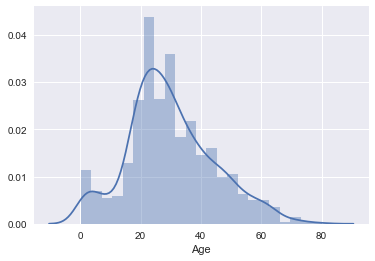

In [95]:
# Age distribution before filling in missing ages

sns.distplot(total.Age[total.Age.notnull()])

In [96]:
total.Age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [97]:
total.loc[total.Age.isnull(), 'Age'] = model.predict(X_test)

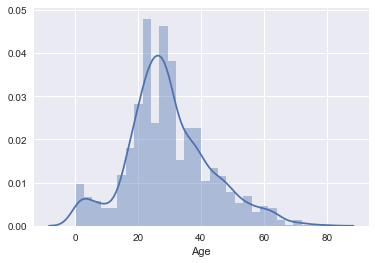

In [98]:
# Age distribution after filling in missing ages

sns.distplot(total.Age)

In [99]:
total.Age.describe()

count    1309.000000
mean       29.800994
std        13.353819
min         0.170000
25%        22.000000
50%        28.000000
75%        37.000000
max        80.000000
Name: Age, dtype: float64

In [100]:
total.isnull().sum().sum()

0

### Modeling

In [117]:
total.shape

(1309, 281)

In [118]:
X = total.head(891)
Y = np.array(train.Survived)
X_test = total.iloc[891:]

In [119]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [120]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

for train_part, test_part in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(1000, use_bias=True, input_dim=281, activation='relu'))
    model.add(Dense(200, use_bias=True, activation='relu'))
    model.add(Dense(20, use_bias=True, activation='relu'))
    model.add(Dense(1, use_bias=True, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X[train_part], Y[train_part], epochs=10, batch_size=1, verbose=0)
    score = model.evaluate(X[test_part], Y[test_part], verbose=1)
    print(score)

 32/177 [====>.........................] - ETA: 2s[0.54433454413198479, 0.82485875773564565]


In [121]:
# Initialize the constructor
model = Sequential()

# Add an input layer
model.add(Dense(1000, use_bias=True, activation='relu', input_shape=(281,)))

# Add one hidden layer
model.add(Dense(200, use_bias=True, activation='relu'))

# Add 1 more hidden layer
model.add(Dense(20, use_bias=True, activation='relu'))

# Add an output layer
model.add(Dense(1, use_bias=True, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X, Y, epochs=10, batch_size=1, verbose=1)

Epoch 1/10
891/891 [==============================] - 7s - loss: 0.5336 - acc: 0.7565     
Epoch 2/10
891/891 [==============================] - 7s - loss: 0.3437 - acc: 0.8709     
Epoch 3/10
891/891 [==============================] - 7s - loss: 0.3114 - acc: 0.8743     
Epoch 4/10
891/891 [==============================] - 7s - loss: 0.2873 - acc: 0.8866     
Epoch 5/10
891/891 [==============================] - 7s - loss: 0.2702 - acc: 0.8923     
Epoch 6/10
891/891 [==============================] - 7s - loss: 0.2632 - acc: 0.8934     
Epoch 7/10
891/891 [==============================] - 7s - loss: 0.2606 - acc: 0.8923     
Epoch 8/10
891/891 [==============================] - 7s - loss: 0.2682 - acc: 0.8889     
Epoch 9/10
891/891 [==============================] - 7s - loss: 0.2624 - acc: 0.8990     
Epoch 10/10
891/891 [==============================] - 7s - loss: 0.2644 - acc: 0.8956     


In [122]:
y_pred = model.predict_classes(X_test, verbose=1)

 32/418 [=>............................] - ETA: 6s

In [123]:
predictions = [item for sublist in y_pred.tolist() for item in sublist]

In [124]:
submission = pd.DataFrame({
             "PassengerId": test.PassengerId,
             "Survived": predictions
             })

# score: 0.80861
submission.to_csv('keras.csv', index=False)